In [ ]:
# !pip install librosa

In [1]:
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple, Union

import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
plt.style.use("ggplot")

# View Data

In [3]:
@dataclass
class Features:
    sample_rate: int = 22050
    hop_length: int = 220
    n_fft: int = 2048
    n_frames_per_example: int = 1


def load_wav(path: Union[str, Path], sample_rate: int) -> np.ndarray:
    waveform, _ = librosa.load(path, sr=sample_rate)
    return waveform


def extract_features(file_path: Union[str, Path], params: Features) -> List[np.ndarray]:
    waveform = load_wav(file_path, sample_rate=params.sample_rate)

    spectrogram = librosa.feature.melspectrogram(
        y=waveform, n_fft=params.n_fft, hop_length=params.hop_length
    )

    spectrogram = np.log(1e-20 + np.abs(spectrogram**2))
    # print("spectrogram", spectrogram.shape, spectrogram.shape[1])

    n_examples = spectrogram.shape[1] // params.n_frames_per_example
    # print("examples", n_examples)

    # return np.concatenate(
    #     [spectrogram.mean(1), log_mel_spectrogram.std(1)]
    # ).reshape(1, -1)

    # return log_mel_spectrogram.mean(1).reshape(1, -1)

    return  [
        spectrogram[
            :, i * params.n_frames_per_example : (i + 1) * params.n_frames_per_example
        ].reshape(1, -1)
        for i in range(n_examples)
    ]

In [147]:
path = "./train/train/classical/1161154212832220511.wav"
hop_length = 220
n_fft = 2048
sample_rate = 22050
waveform = load_wav(path, sample_rate=sample_rate)
ipd.display(ipd.Audio(path))
spectrogram = librosa.feature.melspectrogram(
    y=waveform, n_fft=n_fft, hop_length=hop_length
)
spectrogram = np.log(1e-20 + np.abs(spectrogram**2))

In [151]:
spectrogram[0, :].shape

(602,)

(40, 1, 1920)


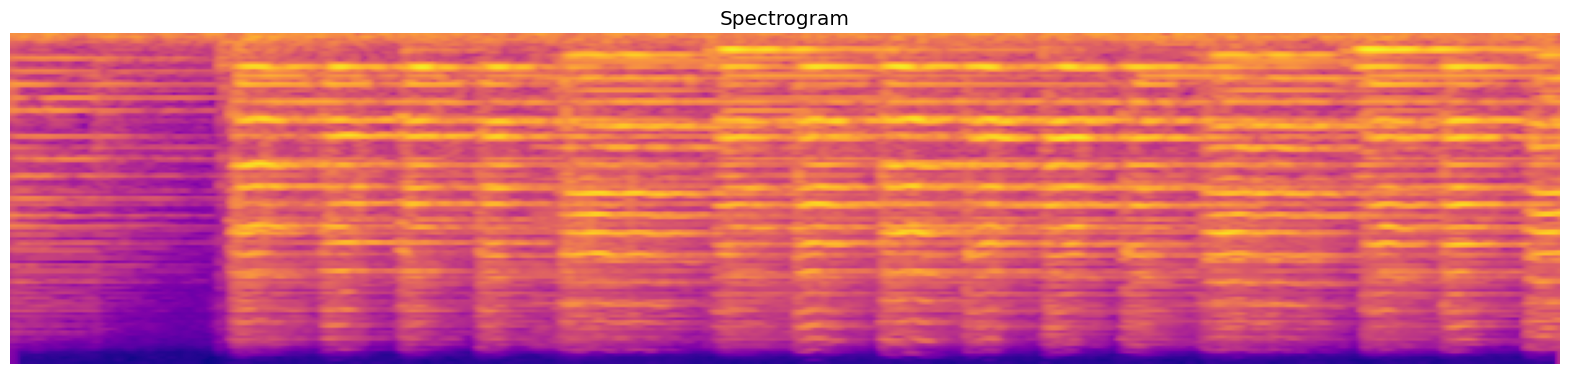

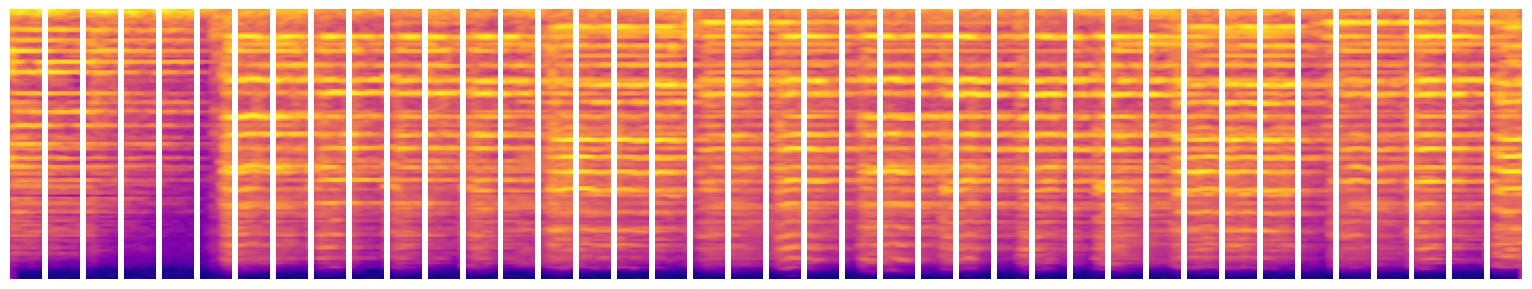

In [72]:
# 1161154212832220511.wav
# 1429195257218202828.wav

PATH = "./train/train/classical/1161154212832220511.wav"
PARAMS = Features(n_frames_per_example=15)

ipd.display(ipd.Audio(PATH))

print(np.array(extract_features(file_path=PATH, params=PARAMS)).shape)

sample_features = [
    feature.reshape(-1, PARAMS.n_frames_per_example)
    for feature in extract_features(file_path=PATH, params=PARAMS)
]

# print(np.array(sample_features).shape)

plt.figure(figsize=(20, 5))
plt.title("Spectrogram")
plt.imshow(np.hstack(sample_features), cmap="plasma")
plt.axis("off")
plt.savefig("spectrogram.png", dpi=200)
plt.show()

plt.figure(figsize=(20, 5))
for i, feature in enumerate(sample_features):
    plt.subplot(1, len(sample_features) + 1, i + 1)
    plt.imshow(feature, cmap="plasma")
    plt.axis("off")
plt.show()

# Prepare Train Dataset

In [5]:
def load_folder_data(
    path: Path, train: bool, params: Features
) -> Tuple[List[List[np.ndarray]], List[List[str]], List[Path]]:
    features: List[List[np.ndarray]] = []
    labels: List[List[str]] = []
    file_names: List[Path] = list(path.rglob("*.wav"))

    for file_path in file_names:
        file_features = extract_features(file_path, params)

        features.append(file_features)

        if train:
            class_name = file_path.parent.name
            labels.append([class_name] * len(file_features))
            
    return features, labels, file_names

In [51]:
@dataclass
class ExpConfig:
    features: Features = Features(
        sample_rate=22050,
        hop_length=220,
        n_fft=2048,
        n_frames_per_example,
    )
    random_state: int = 42
    test_size: float = 0.1
    train_path: Path = Path("./train/train")
    test_path: Path = Path("./test/test")


config = ExpConfig()

In [52]:
class_names = [folder.name for folder in config.train_path.iterdir()]

class_name2id: Dict[str, int] = {
    class_name: class_id for class_id, class_name in enumerate(class_names)
}

features, labels, file_names = load_folder_data(
    path=config.train_path, train=True, params=config.features
)

labels_int: List[List[int]] = [
    [class_name2id[label] for label in label_list] for label_list in labels
]

In [53]:
(
    features_train,
    features_test,
    labels_train,
    labels_test,
    files_train,
    files_test,
) = train_test_split(
    features,
    labels_int,
    file_names,
    random_state=config.random_state,
    test_size=config.test_size,
)

In [9]:
# k = 0
# for e in features_test:
#     if len(e) != 602:
#         k += 1
#         print(len(e))
# k

In [69]:
len(features_train[0][0][0])

256

In [54]:
X_train = np.vstack([x for list_ in features_train for x in list_])
y_train = np.array([x for list_ in labels_train for x in list_])

In [71]:
len(X_train[0])

256

In [12]:
# np.unique(y_train[0:1000000], return_counts=True)

In [13]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([240198, 245012, 248622, 240799, 248618, 240198, 251636, 239596,
        240800, 242605], dtype=int64))

In [139]:
from catboost import CatBoostClassifier

In [143]:
%%time

pipe = Pipeline([("scaler", StandardScaler()), ("clf", CatBoostClassifier(max_depth=2))]).fit(
    X_train[0:100000], y_train[0:100000]
)

Learning rate set to 0.100074
0:	learn: 2.2420778	total: 182ms	remaining: 3m 1s
1:	learn: 2.1920796	total: 379ms	remaining: 3m 9s
2:	learn: 2.1463366	total: 617ms	remaining: 3m 25s
3:	learn: 2.1093677	total: 805ms	remaining: 3m 20s
4:	learn: 2.0843956	total: 985ms	remaining: 3m 16s
5:	learn: 2.0489942	total: 1.2s	remaining: 3m 18s
6:	learn: 2.0258087	total: 1.38s	remaining: 3m 15s
7:	learn: 1.9974150	total: 1.6s	remaining: 3m 18s
8:	learn: 1.9765406	total: 1.79s	remaining: 3m 17s
9:	learn: 1.9556436	total: 1.96s	remaining: 3m 14s
10:	learn: 1.9350838	total: 2.17s	remaining: 3m 15s
11:	learn: 1.9187406	total: 2.34s	remaining: 3m 12s
12:	learn: 1.9008447	total: 2.56s	remaining: 3m 14s
13:	learn: 1.8884941	total: 2.73s	remaining: 3m 12s
14:	learn: 1.8769903	total: 2.89s	remaining: 3m 10s
15:	learn: 1.8625161	total: 3.08s	remaining: 3m 9s
16:	learn: 1.8506613	total: 3.28s	remaining: 3m 9s
17:	learn: 1.8415371	total: 3.43s	remaining: 3m 7s
18:	learn: 1.8301386	total: 3.63s	remaining: 3m 7s


# Interpretation

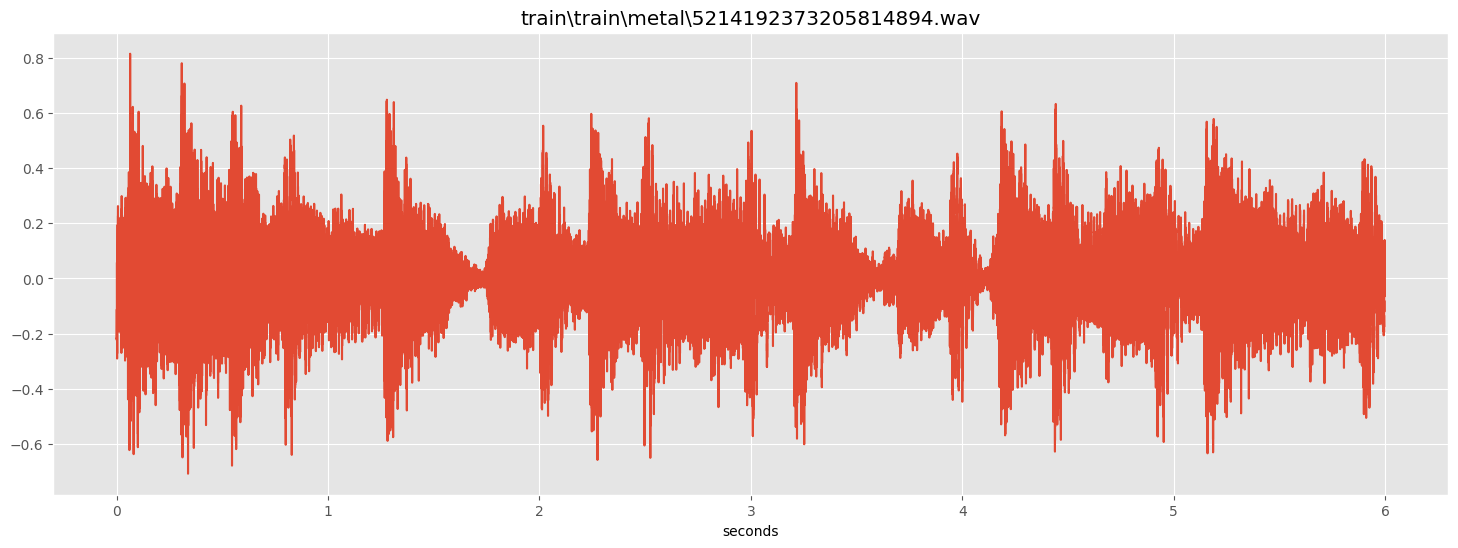

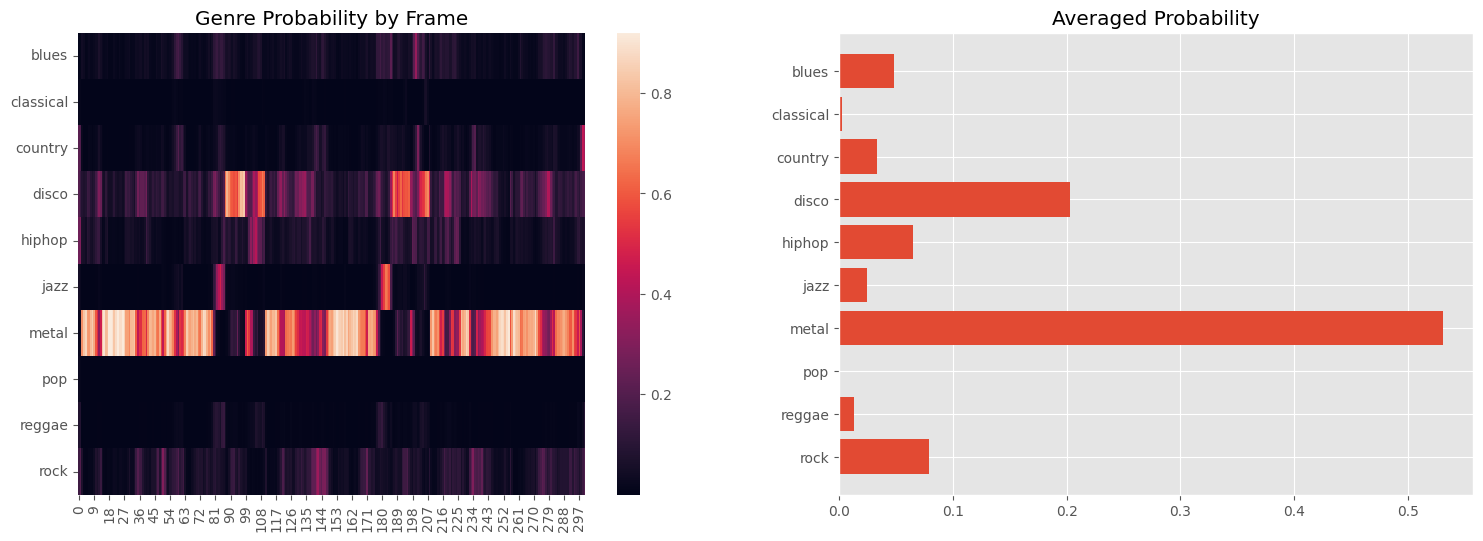

In [144]:
TEST_ID = 892

predictions = pipe.predict_proba(np.vstack(features_train[TEST_ID]))

plt.figure(figsize=(18, 6))
plt.title(files_train[TEST_ID])
wave_form = load_wav(files_train[TEST_ID], sample_rate=config.features.sample_rate)
time_axis = [x / config.features.sample_rate for x in range(wave_form.size)]
plt.plot(time_axis, wave_form)
plt.xlabel("seconds")
plt.show()

ipd.display(ipd.Audio(files_train[TEST_ID]))
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.title("Genre Probability by Frame")
sns.heatmap(predictions.T, yticklabels=class_names)

plt.subplot(122)
plt.title("Averaged Probability")
plt.barh(class_names, predictions.mean(0))
plt.gca().invert_yaxis()
plt.show()

## Confusion matrix

In [136]:
def plot_conf_matrix(
    y_test: np.ndarray, y_pred: np.ndarray, class_names: List[str], annot: bool = False
) -> None:
    plt.figure(figsize=(8, 6))
    plt.title(f"Accuracy: {(y_test == y_pred).mean():.2f}")
    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        xticklabels=class_names,
        yticklabels=class_names,
        linewidths=0.5,
        annot=annot,
    )
    plt.show()

### by frame

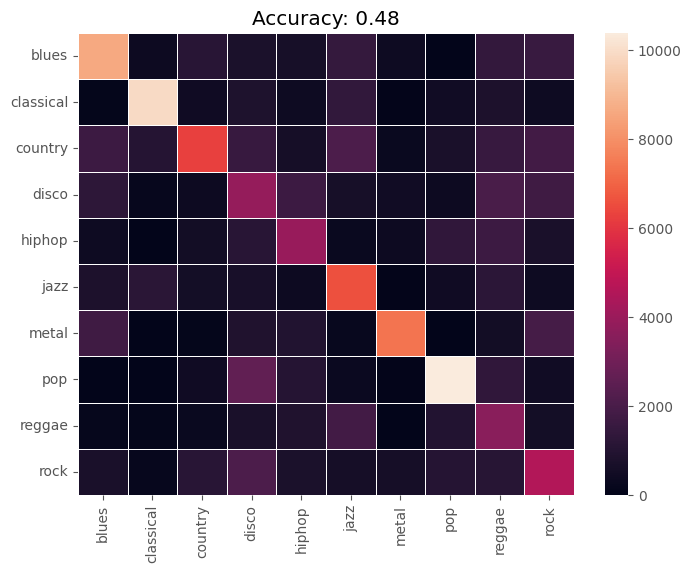

In [145]:
X_test = np.vstack(
    [feature for feature_list in features_test for feature in feature_list]
)

y_test = np.array([label for label_list in labels_test for label in label_list])

y_pred = pipe.predict(X_test).reshape(-1)

plot_conf_matrix(y_pred, y_test, class_names)

### by record

In [98]:
len(features_test)

450

In [120]:
pipe.predict_proba(np.vstack(features_test[0])).mean(axis=0).argmax()

9

In [116]:
arr = pipe.predict_proba(np.vstack(features_test[0]))

In [121]:
def get_best_genre(arr):
    max_in_a_row = 0
    last = -1
    in_a_row = 0
    best_genre = 0
    for episode in arr:
        i = episode.argmax()
        if i == last:
            in_a_row += 1
        else:
            in_a_row = 0
        if in_a_row > max_in_a_row:
            best_genre = i
            max_in_a_row = in_a_row
        last = i
    return best_genre

9

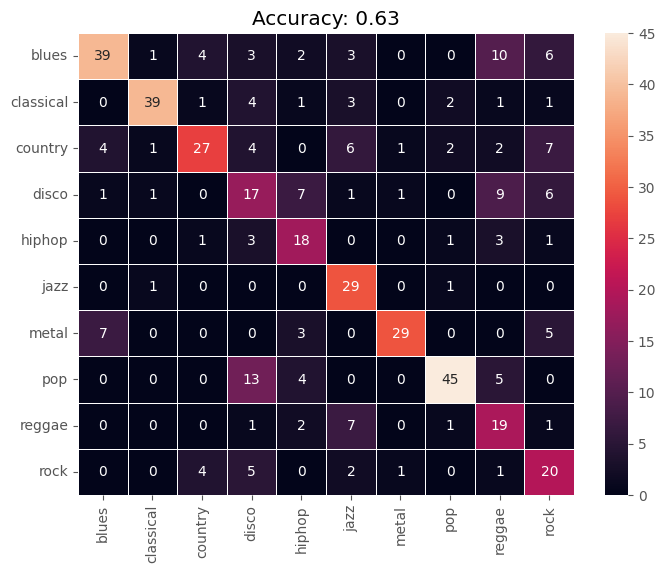

In [146]:
y_pred = np.array(
    [
        pipe.predict_proba(np.vstack(feature_list)).mean(axis=0).argmax()
        for feature_list in features_test
    ]
)

y_test = np.array([label_list[0] for label_list in labels_test])

plot_conf_matrix(y_pred, y_test, class_names, annot=True)

# Test

In [16]:
test_features, _, test_pathes = load_folder_data(
    config.test_path, train=False, params=config.features
)

In [17]:
predictions = [
    class_names[pipe.predict_proba(np.vstack(test_feature)).mean(0).argmax()]
    for test_feature in test_features
]

In [18]:
(
    pd.DataFrame(
        {
            "index": [
                test_wav_path.name for test_wav_path in config.test_path.iterdir()
            ],
            "genre": predictions,
        }
    ).to_csv("submit.csv", index=False)
)